# Machine Learning for Medicine
# **Data Integration with Deep Learning**.
# **MLP on the Breast Cancer Dataset and the Dataset from Golub et al. 1999**.
> * Student : **Merrouche Aymen**

## **Introduction**
> In this notebook we train a deep learning architecture, precisely a **two layers feed forward neural network**, for a **binary classification** task on two medical datasets: the **breast cancer dataset** and the dataset from **Golub et al. 1999**. We will use both keras and sklearn and compare the results obtained with these two frameworks. Moreover, we will use grid search to select the optimal hyperparameters and then explore the parameter space to define finer grained grids. Finally, we will compare the results obtained with this deep learning approach and the results yielded by traditional machine learning algorithms, namely: **SVM**, **Gradient Boosting** and **Random Forests**.
> We get the following final results :
<img src=./figs/comparison_mlp_ml.png>

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
# utils
import joblib
import matplotlib.pyplot as plt
import time

# coded functions
from models import *
from utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

## Import medical data :

### Breast cancer data set : 
> Describes wheather a breast mas is malignant or not based on cell nuclei characteristics.

In [3]:
# import the data
breast_cancer = pd.read_csv("data/Breast.txt",sep=" ")
breast_cancer_y = breast_cancer.values[:,30] # Classes
breast_cancer_X = breast_cancer.values[:,0:29] # Observations

In [4]:
print("Number of examples :", breast_cancer_X.shape[0])
print("Dimension of the problem :", breast_cancer_X.shape[1])
print("Number of classes :", np.unique(breast_cancer_y).shape[0])

Number of examples : 568
Dimension of the problem : 29
Number of classes : 2


#### **Most Discriminative Features :**
> Let's display the variables with the largest variance :

In [5]:
# some statistics
std_pd_breast = pd.DataFrame(breast_cancer_X).describe().T.sort_values(by=['std'], ascending=False)
std_pd_breast.head()

,count,mean,std,min,25%,50%,75%,max
14,568.0,0.000376,1.000841,-1.774504,-0.624386,-0.221973,0.369697,8.022940
11,568.0,0.000994,1.000600,-1.552898,-0.695558,-0.194605,0.466595,6.649429
17,568.0,-0.001162,1.000497,-1.911765,-0.674464,-0.141993,0.472241,6.643755
16,568.0,-0.001274,1.000419,-1.056571,-0.557582,-0.199387,0.327015,12.062067
19,568.0,-0.001596,1.000156,-1.096004,-0.585927,-0.239375,0.276201,9.842932


#### **Variance Across Feature Variances :**
> Let's see what is the variance of feature variances (wether there are features that are more discriminative than others) :

In [6]:
std_pd_breast.describe()

,count,mean,std,min,25%,50%,75%,max
count,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,568.0,-0.002638,0.997502,-1.675659,-0.677661,-0.219632,0.457734,5.903085
std,0.0,0.002248,0.002502,0.562173,0.061536,0.096006,0.140386,2.367050
min,568.0,-0.005776,0.991337,-3.109349,-0.758778,-0.398531,0.102887,2.683516
25%,568.0,-0.004376,0.995414,-1.982759,-0.722358,-0.285878,0.362975,4.239858
50%,568.0,-0.003319,0.997347,-1.608721,-0.689489,-0.223734,0.472241,4.906602
75%,568.0,-0.001732,0.999718,-1.260710,-0.642142,-0.181663,0.529661,6.649429
max,568.0,0.003647,1.000841,-0.737180,-0.494319,-0.035216,0.710743,12.062067


> We can see that the std across feature variances is relatively small (0.0025) meaning that the different features have similar variances.

#### **Class Count :**

In [7]:
pd.DataFrame(breast_cancer_y).apply(pd.value_counts)

,0
1.0,357
-1.0,211


> We can remark a small class imbalance.

### For the Golub et al. 1999 dataset :
> Molecular classification of leukemia data set of Golub et al. 1999 contains gene expressions of 72 patients and 3562 genes.

In [8]:
golub_X = pd.read_csv('data/Golub_X',sep=' ') # Observations
golub_y = pd.read_csv('data/Golub_y',sep=' ') # Classes

In [9]:
print("Number of examples :", golub_X.shape[0])
print("Dimension of the problem :", golub_X.shape[1])
print("Number of classes :", np.unique(golub_y).shape[0])

Number of examples : 71
Dimension of the problem : 3562
Number of classes : 2


#### **Most Discriminative Features :**
> Let's display the variables with the largest variance :

In [10]:
# some statistics
std_pd_golub = pd.DataFrame(golub_X).describe().T.sort_values(by=['std'], ascending=False)
std_pd_golub.head()

,count,mean,std,min,25%,50%,75%,max
0.977353992848629,71.0,0.442730,0.277979,0.0,0.228248,0.439809,0.633492,1.0
0.789333706606943,71.0,0.399919,0.274733,0.0,0.120276,0.415314,0.599839,1.0
0.37202238903111,71.0,0.531141,0.271993,0.0,0.319391,0.584154,0.756281,1.0
0.392533936651584,71.0,0.657288,0.269132,0.0,0.499434,0.748869,0.850679,1.0
0.103026597370835,71.0,0.302238,0.265903,0.0,0.118618,0.206359,0.362427,1.0


#### **Variance Across Feature Variances :**
> Let's see what is the variance of feature variances (wether there are features that are more discriminative than others) :

In [11]:
std_pd_golub.describe()

,count,mean,std,min,25%,50%,75%,max
count,3562.0,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000
mean,71.0,0.407606,0.188245,0.000207,0.290400,0.390872,0.505042,0.999364
std,0.0,0.151869,0.030125,0.004764,0.157167,0.173771,0.180842,0.012174
min,71.0,0.019976,0.096218,0.000000,0.004764,0.005782,0.007077,0.612648
25%,71.0,0.301674,0.167521,0.000000,0.172658,0.265776,0.387243,1.000000
50%,71.0,0.403153,0.189293,0.000000,0.269913,0.383022,0.513563,1.000000
75%,71.0,0.509486,0.209992,0.000000,0.393261,0.511095,0.633366,1.000000
max,71.0,0.942733,0.277979,0.192095,0.948830,0.956292,0.976465,1.000000


> We can see that the std across feature variances is large compared with the breast cancer dataset (0.0025 vs 0.03).

#### **Class Count :**

In [12]:
pd.DataFrame(golub_y).apply(pd.value_counts)

,0
0,46
1,25


> We observe a similar class imbalance with the breast cancer dataset.

In [13]:
medical_data = {"breast" : (pd.DataFrame(breast_cancer_X), breast_cancer_y), "golub" : (golub_X, np.squeeze(golub_y.values, axis=1))}

# 1 - Binary Classification on the Breast Cancer Dataset :

In [14]:
# get the data
breast_X_train, breast_X_test, breast_y_train, breast_y_test = train_test_split(medical_data["breast"][0], medical_data["breast"][1], test_size=0.33, random_state=42)
print("Number of examples in train : ", breast_X_train.shape[0])
print("Number of examples in test : ", breast_X_test.shape[0])

Number of examples in train :  380
Number of examples in test :  188


## 1 - 2- Using Sklearn :
> In this subsection we use sklearn's MLP to perform binary classification on our breast cancer dataset with Sklearn. For hyperparameter tuning we will use grid search with a 10 folds cross validation.

**1 - Let's create our model :**

In [15]:
# declare our MLP
# we set the number of epochs to 100, the dataset is relatively small 
# and the task is not complicated so that should be enough
mlp_breast_sklearn = MLPClassifier(max_iter=100)

**2 - Parameter Space and GridSearch :**

In [16]:
# hyperparameters to test

# hidden layers
hidden_layers = []
pow_2 = [ 2**j for j in range(4,10)]
for i in range(len(pow_2)-1):
    hidden_layers.append((pow_2[i], pow_2[i+1]))
# l2 regularization
alpha = [10**-i for i in range(2, 5)]
# learning rate
lr = [10**-i for i in range(2, 5)]
# batch size
batch_size = [ 2**j for j in range(4,8)]


# parameter space
parameter_space = {
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'learning_rate_init': lr,
    'batch_size' : batch_size
}
print("parameters to test : ", parameter_space)

parameters to test :  {'hidden_layer_sizes': [(16, 32), (32, 64), (64, 128), (128, 256), (256, 512)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.001, 0.0001], 'learning_rate': ['constant', 'adaptive', 'invscaling'], 'learning_rate_init': [0.01, 0.001, 0.0001], 'batch_size': [16, 32, 64, 128]}


**4 - Results :**

In [17]:
# We perform our grid search and get the best found accuracy (and other metrics)
clf_breast_sk = GridSearchCV(mlp_breast_sklearn, parameter_space, n_jobs=-1, cv=10, verbose=1)
t0 = time.time()
clf_breast_sk.fit(breast_X_train, breast_y_train)
t1 = time.time()
print("Grid Search took : ", (t1-t0)/60, " mn")

Fitting 10 folds for each of 2160 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 55.8min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 62.8min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

Grid Search took :  131.27149532238641  mn


In [18]:
joblib.dump(clf_breast_sk.cv_results_, './cv_results/cv_results_breast_sk.pkl')
cv_results_breast_sk = joblib.load("./cv_results/cv_results_breast_sk.pkl")

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 128, 'hidden_layer_sizes': (64, 128), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
Best accuracy:  0.9894736842105264


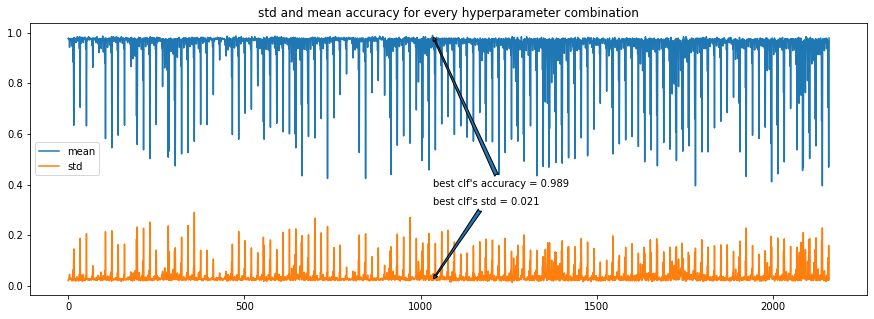

In [19]:
############################## RESULTS

# Best paramete set
print('Best parameters found:\n', clf_breast_sk.best_params_)
print('Best accuracy: ', clf_breast_sk.best_score_)


# All results
means = clf_breast_sk.cv_results_['mean_test_score']
stds = clf_breast_sk.cv_results_['std_test_score']
# show std and mean for every combination
"""for mean, std, params in zip(means, stds, clf_breast_sk.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

# plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(means, label="mean")
plt.plot(stds, label="std")

# localise best param combination
xmax = clf_breast_sk.best_index_
accmax = means[xmax]
stdmax = stds[xmax]

ax.annotate('best clf\'s accuracy = '+"%.3f" % accmax, xy=(xmax, accmax), xytext=(xmax, accmax-0.6),arrowprops=dict(arrowstyle ='fancy'))
ax.annotate('best clf\'s std = '+"%.3f" % stdmax, xy=(xmax, stdmax), xytext=(xmax, stdmax+0.3),arrowprops=dict(arrowstyle ='fancy'))

plt.title("std and mean accuracy for every hyperparameter combination")
plt.legend(loc="best")
plt.show()

> The best model is an MLP with parameters shown in the previous cell.
> By plotting the mean accuracy and standard deviation (across splits), we see the importance of hyperparameter tuning. Some parameter combinations yield poor performances (low accuracy and high std, for example $0.45$, $0.23$ respectively). Whereas the best classifier associated with the above mentioned parameters yields a mean accuracy of $0.98$ and a standard deviation of $0.021$.

> Let's see the results that we obtain on the set:

In [20]:
breast_y_test, breast_y_pred = breast_y_test , clf_breast_sk.predict(breast_X_test)
print('We get the following results on the test set :')
print(classification_report(breast_y_test, breast_y_pred))

We get the following results on the test set :
              precision    recall  f1-score   support

        -1.0       0.97      0.94      0.96        72
         1.0       0.97      0.98      0.97       116

    accuracy                           0.97       188
   macro avg       0.97      0.96      0.97       188
weighted avg       0.97      0.97      0.97       188



> We obtain a very good accuracy score of $0.97$ on the test.

## 1 - 2 - Using Keras :
> In this subsection we use sklearn's MLP to perform binary classification on our breast cancer dataset with keras. For hyperparameter tuning we will use grid search with a 10 folds cross validation. We will try to fine tune the same hyperparameters in order to compare the results afterwards (however more parameters are available in keras :  droupout, weight initialisation...).

**1 - Let's create our model :**
> It is in the models.py file to reduce the length of the notebook.

In [21]:
# test shapes
import tensorflow as tf
mlp_toy_keras = MLP(2, 2)
x = tf.ones((3, 2))
y = mlp_toy_keras(x)
print(y)

tf.Tensor(
[[0.44743565 0.5525643 ]
 [0.44743565 0.5525643 ]
 [0.44743565 0.5525643 ]], shape=(3, 2), dtype=float32)


**2 - Get input dim and number of classes :**

In [96]:
input_dim = medical_data["breast"][0].shape[1]
num_classes = np.unique(medical_data["breast"][1]).shape[0]
print("input dim : ", input_dim)
print("num classes : ", num_classes)

input dim :  29
num classes :  2


**3 - Parameter Space and GridSearch :**
> In order to perform Sklearn's GridSearch we wrap our model with the **KerasClassifier** class.

In [23]:
mlp_breast_keras = KerasClassifier(build_fn=MLP, verbose=0)

In [24]:
# hyperparameters to test

# hidden layers
hidden_layers = []
pow_2 = [ 2**j for j in range(4,10)]
for i in range(len(pow_2)-1):
    hidden_layers.append((pow_2[i], pow_2[i+1]))
# l2 regularization
alpha = [10**-i for i in range(2, 5)]
# learning rate
lr = [10**-i for i in range(2, 5)]
# batch size
batch_size = [ 2**j for j in range(4,8)]


# parameter space
parameter_space = {
    'input_dim' : [input_dim],
    'num_classes' : [num_classes],
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    'learning_rate_init': lr,
    'batch_size' : batch_size,
    'epochs' : [100]
}
print("parameters to test : ", parameter_space)

parameters to test :  {'input_dim': [29], 'num_classes': [2], 'hidden_layer_sizes': [(16, 32), (32, 64), (64, 128), (128, 256), (256, 512)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.001, 0.0001], 'learning_rate_init': [0.01, 0.001, 0.0001], 'batch_size': [16, 32, 64, 128], 'epochs': [100]}


In [25]:
# We perform our grid search and get the best found accuracy (and other metrics)
clf_breast_keras = GridSearchCV(mlp_breast_keras, parameter_space, n_jobs=-1, cv=10, verbose=1)
t0 = time.time()
clf_breast_keras.fit(breast_X_train, breast_y_train)
t1 = time.time()
print("Grid Search took : ", (t1-t0)/60, " mn")

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 31.8min finished


Grid Search took :  31.76236621141434  mn


In [26]:
joblib.dump(clf_breast_keras.cv_results_, './cv_results/cv_results_breast_keras.pkl')
cv_results_breast_keras = joblib.load("./cv_results/cv_results_breast_keras.pkl")

**4 - Results :**

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'epochs': 100, 'hidden_layer_sizes': (256, 512), 'input_dim': 29, 'learning_rate_init': 0.01, 'num_classes': 2, 'solver': 'sgd'}
Best accuracy:  0.9868421018123626


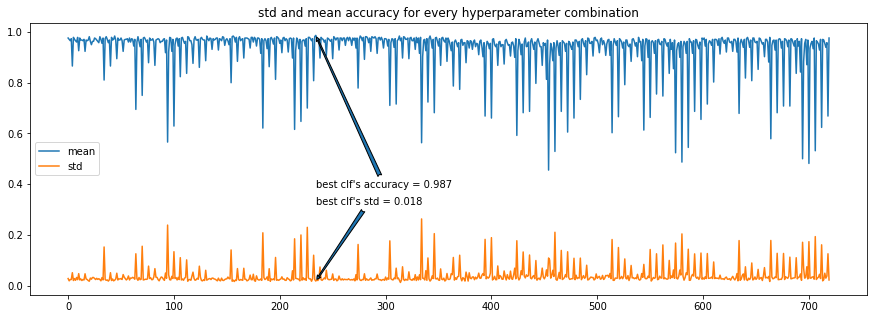

In [27]:
############################## RESULTS

# Best paramete set
print('Best parameters found:\n', clf_breast_keras.best_params_)
print('Best accuracy: ', clf_breast_keras.best_score_)


# All results
means = clf_breast_keras.cv_results_['mean_test_score']
stds = clf_breast_keras.cv_results_['std_test_score']
# show std and mean for every combination
"""for mean, std, params in zip(means, stds, clf_breast_sk.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

# plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(means, label="mean")
plt.plot(stds, label="std")

# localise best param combination
xmax = clf_breast_keras.best_index_
accmax = means[xmax]
stdmax = stds[xmax]

ax.annotate('best clf\'s accuracy = '+"%.3f" % accmax, xy=(xmax, accmax), xytext=(xmax, accmax-0.6),arrowprops=dict(arrowstyle ='fancy'))
ax.annotate('best clf\'s std = '+"%.3f" % stdmax, xy=(xmax, stdmax), xytext=(xmax, stdmax+0.3),arrowprops=dict(arrowstyle ='fancy'))

plt.title("std and mean accuracy for every hyperparameter combination")
plt.legend(loc="best")
plt.show()

> The best model is an MLP with parameters shown in the previous cell. The parameters found are different from the ones found with sklearn's MLP, we attribute this to the randomness in splitting the data from one side, and the small size of the training set on the other.
> By plotting the mean accuracy and standard deviation (across splits), we see the importance of hyperparameter tuning. Some parameter combinations yield poor performances (low accuracy and high std, for example $0.45$, $0.23$ respectively). Whereas the best classifier associated with the above-mentioned parameters yields a mean accuracy of $0.98$ and a standard deviation of $0.018$.

In [28]:
breast_y_test, breast_y_pred = breast_y_test , clf_breast_keras.predict(breast_X_test)
print('We get the following results on the test set :')
print(classification_report(breast_y_test, breast_y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
We get the following results on the test set :
              precision    recall  f1-score   support

        -1.0       0.97      0.96      0.97        72
         1.0       0.97      0.98      0.98       116

    accuracy                           0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



> We obtain exactly the same score on the test set (compared with sklearn's MLP).

## 1 - 3 - Trends in Parameter Space :
> In this subsection, we will analyse the results obtained across the parameter space. We will see if there are trends (wrt to accuracy and std) in this space. This allows to zoom on parts of the parameter space that seem optimal and design finer grained grids.

**1 - Optimisation : Learning Rate vs Batch Size vs Optimizer :**

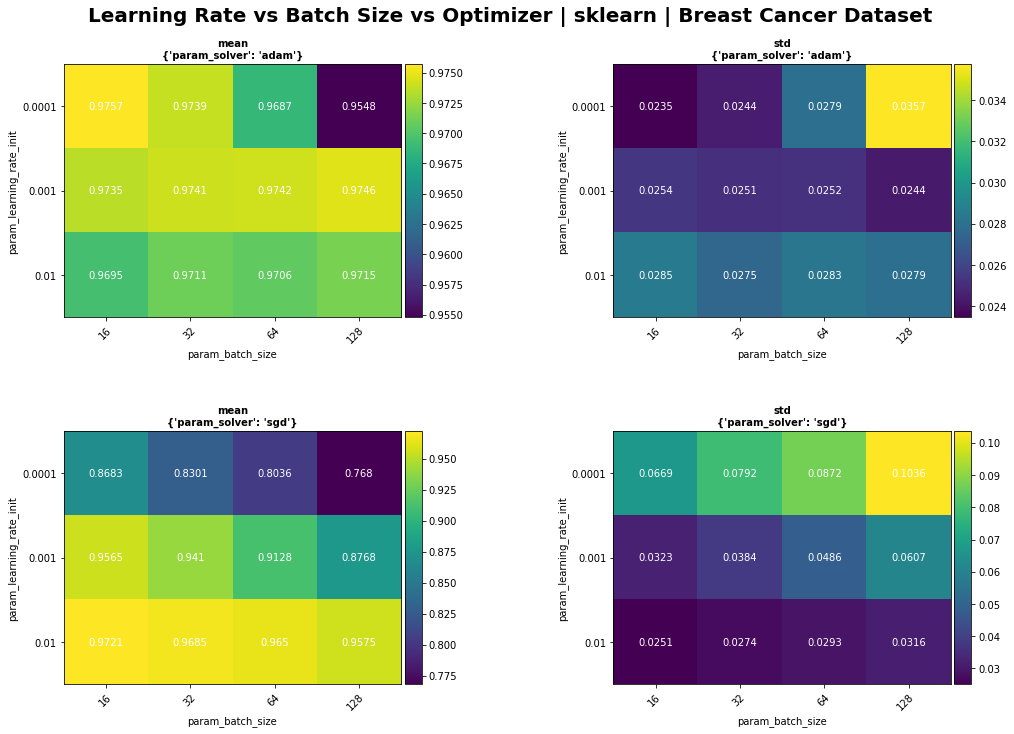

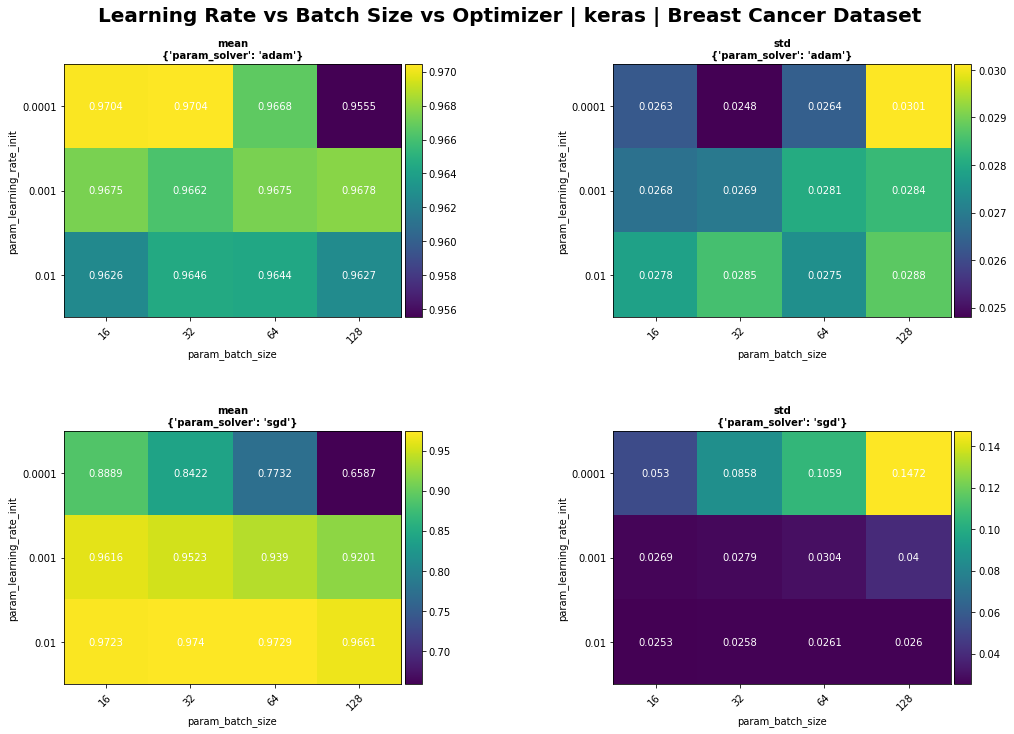

In [29]:
cv_results_breast = {"sklearn":cv_results_breast_sk,"keras":cv_results_breast_keras}
param_names = ["param_learning_rate_init", "param_batch_size"]
with_values = [{"param_solver" : "adam"}, {"param_solver" : "sgd"}]
for i,cv_res in enumerate(cv_results_breast):
    cv_result = cv_results_breast[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle("Learning Rate vs Batch Size vs Optimizer | "+cv_res+" | Breast Cancer Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.15, hspace = 0.45)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

**2 - Network : Hidden Layers vs $\alpha$ the weight of the $l_2$ regularization vs Activation :**

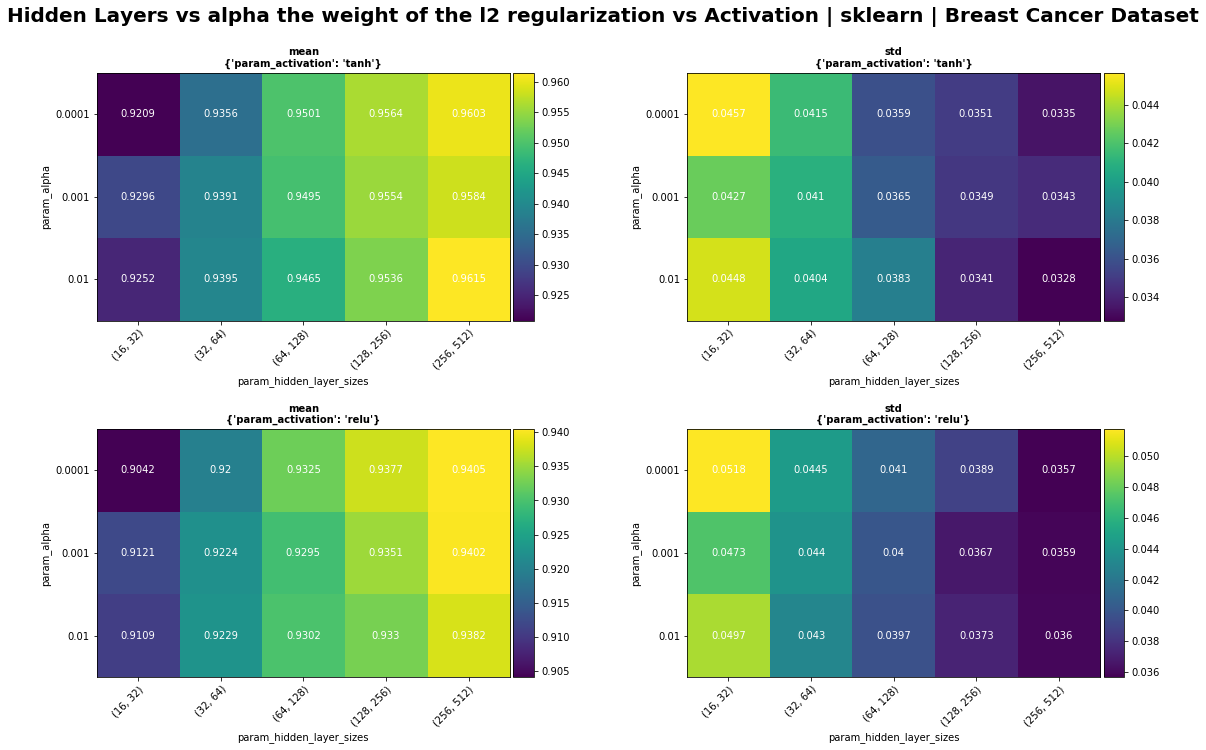

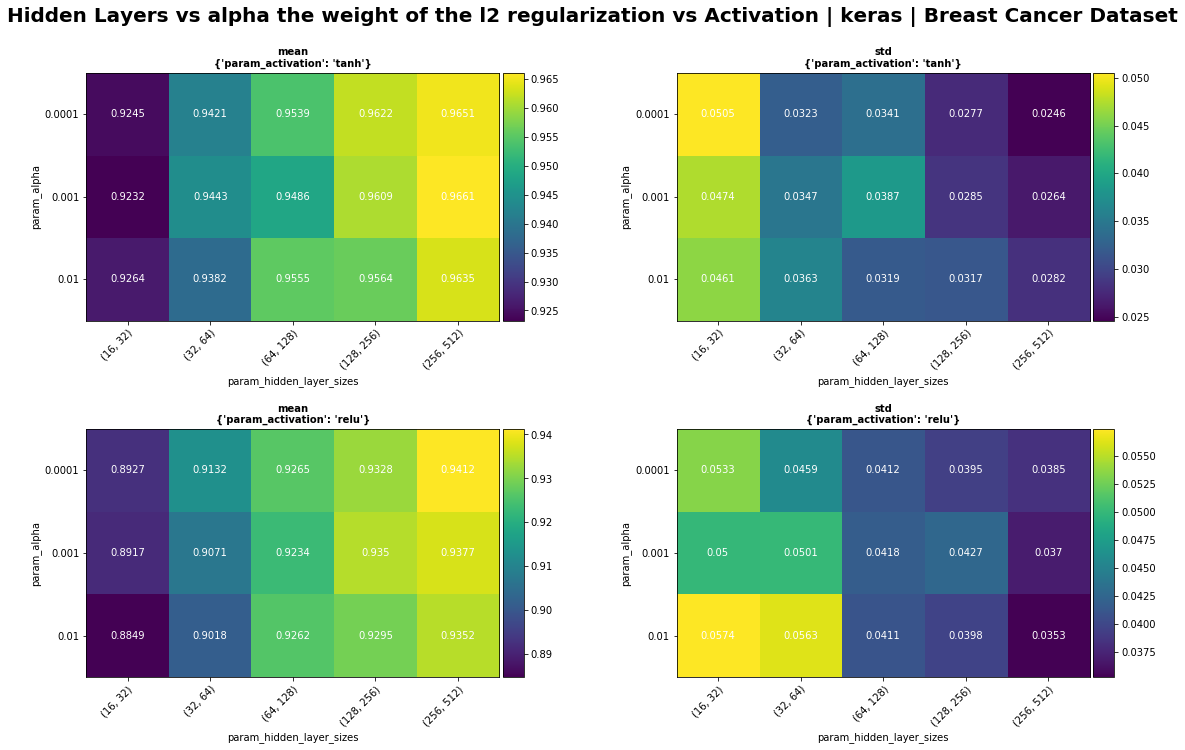

In [30]:
cv_results_breast = {"sklearn":cv_results_breast_sk,"keras":cv_results_breast_keras}
param_names = ["param_alpha", "param_hidden_layer_sizes"]
with_values = [{"param_activation" : "tanh"}, {"param_activation" : "relu"}]
for i,cv_res in enumerate(cv_results_breast):
    cv_result = cv_results_breast[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle("Hidden Layers vs alpha the weight of the l2 regularization vs Activation | "+cv_res+" | Breast Cancer Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.35, wspace= 0.35)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

**3 - The Most Discriminative Network Parameter vs The Most Discriminative Optimisation Parameters : Hidden Layers vs batch_size vs Learning Rate**

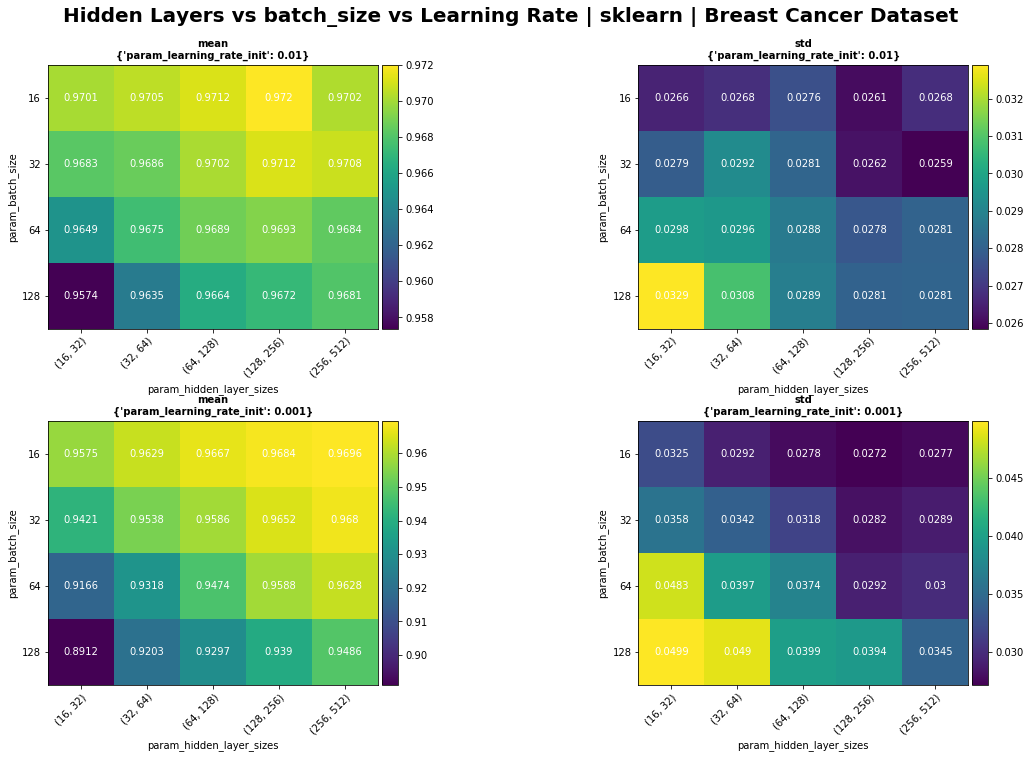

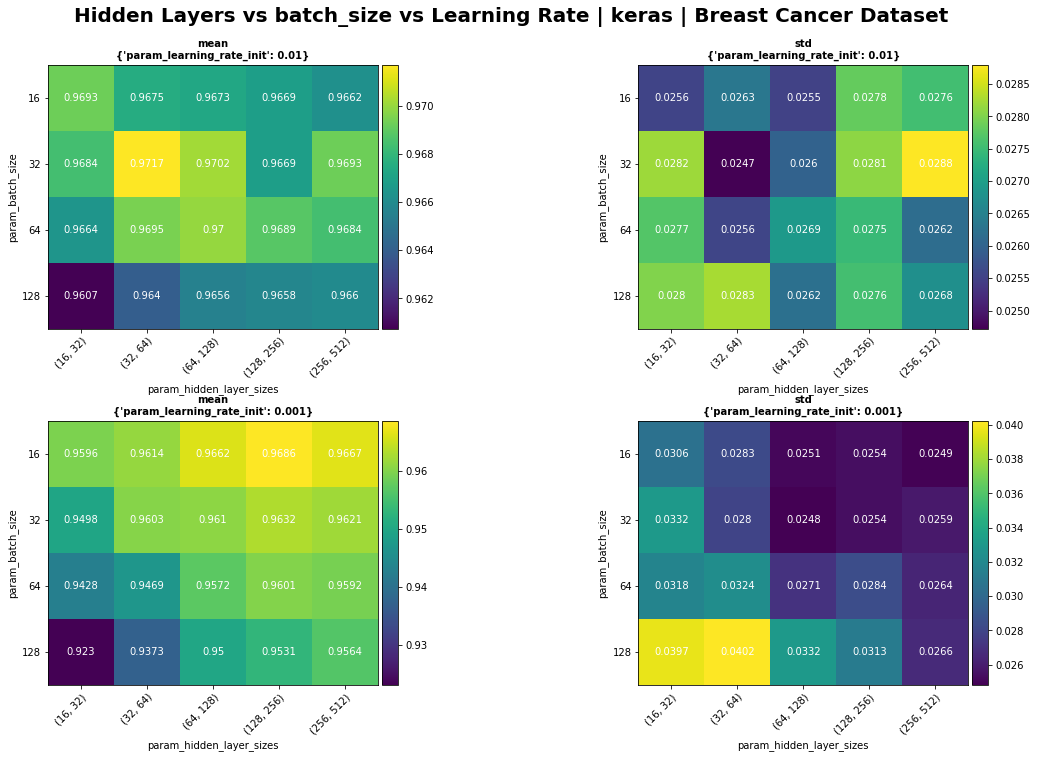

In [31]:
cv_results_breast = {"sklearn":cv_results_breast_sk,"keras":cv_results_breast_keras}
param_names = ["param_batch_size", "param_hidden_layer_sizes"]
with_values = [{"param_learning_rate_init" : 0.01}, {"param_learning_rate_init" : 0.001}]
for i,cv_res in enumerate(cv_results_breast):
    cv_result = cv_results_breast[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle("Hidden Layers vs batch_size vs Learning Rate | "+cv_res+" | Breast Cancer Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.35, wspace= 0.35)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

## 1 - 4 - Finer Grained Grids :
>In this subsection, we will make use of the results obtained by exploring the parameter space to design finer grained grids, we only test on keras's MLP (but his is also valid for sklearn since we obtained very similar results).

In [97]:
# hyperparameters to test

# hidden layers
hidden_layers = [(32, 64)]
# l2 regularization
alpha = [1e-4, 5e-4, 1e-5, 5e-5]
# learning rate
lr = [0.1, 0.05, 0.08, 0.01]
# batch size
batch_size = [50, 64, 70]


# parameter space
finer_grained_parameter_space = {
    'input_dim' : [input_dim],
    'num_classes' : [num_classes],
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    'learning_rate_init': lr,
    'batch_size' : batch_size,
    'epochs' : [100]
}
print("parameters to test : ", finer_grained_parameter_space)

parameters to test :  {'input_dim': [29], 'num_classes': [2], 'hidden_layer_sizes': [(32, 64)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.0005, 1e-05, 5e-05], 'learning_rate_init': [0.1, 0.05, 0.08, 0.01], 'batch_size': [50, 64, 70], 'epochs': [100]}


In [98]:
mlp_breast_keras = KerasClassifier(build_fn=MLP, verbose=0)

In [99]:
%%time
# We perform our grid search and get the best found accuracy (and other metrics)
clf_breast_keras_finer_grained = GridSearchCV(mlp_breast_keras, finer_grained_parameter_space, n_jobs=-1, cv=10, verbose=1)
t0 = time.time()
clf_breast_keras_finer_grained.fit(breast_X_train, breast_y_train)
t1 = time.time()
print("Grid Search took : ", (t1-t0)/60, " mn")

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.7min finished


Grid Search took :  4.744491938749949  mn
CPU times: user 4.28 s, sys: 452 ms, total: 4.73 s
Wall time: 4min 44s


In [100]:
joblib.dump(clf_breast_keras_finer_grained.cv_results_, './cv_results/cv_results_breast_keras_finer_grained.pkl')
cv_results_breast_keras_finer_grained = joblib.load("./cv_results/cv_results_breast_keras_finer_grained.pkl")

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 70, 'epochs': 100, 'hidden_layer_sizes': (32, 64), 'input_dim': 29, 'learning_rate_init': 0.01, 'num_classes': 2, 'solver': 'sgd'}
Best accuracy:  0.989473682641983


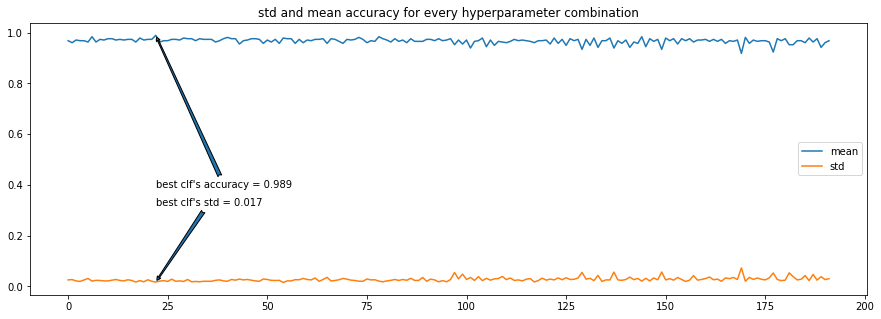

In [101]:
############################## RESULTS

# Best paramete set
print('Best parameters found:\n', clf_breast_keras_finer_grained.best_params_)
print('Best accuracy: ', clf_breast_keras_finer_grained.best_score_)


# All results
means = clf_breast_keras_finer_grained.cv_results_['mean_test_score']
stds = clf_breast_keras_finer_grained.cv_results_['std_test_score']
# show std and mean for every combination
"""for mean, std, params in zip(means, stds, clf_breast_sk.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

# plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(means, label="mean")
plt.plot(stds, label="std")

# localise best param combination
xmax = clf_breast_keras_finer_grained.best_index_
accmax = means[xmax]
stdmax = stds[xmax]

ax.annotate('best clf\'s accuracy = '+"%.3f" % accmax, xy=(xmax, accmax), xytext=(xmax, accmax-0.6),arrowprops=dict(arrowstyle ='fancy'))
ax.annotate('best clf\'s std = '+"%.3f" % stdmax, xy=(xmax, stdmax), xytext=(xmax, stdmax+0.3),arrowprops=dict(arrowstyle ='fancy'))

plt.title("std and mean accuracy for every hyperparameter combination")
plt.legend(loc="best")
plt.show()

> We can obviously see that we are exploring an optimal part of parameter space. Compared with previous plots of cross-validation score and std, the above plots are much smoother and settle around optimal values (0.98 for accuracy and 0.01 for std). By a fine grained grid search we obtained a better cross-validation score (0.989 compared with 0.987).

In [102]:
breast_y_test, breast_y_pred = breast_y_test , clf_breast_keras_finer_grained.predict(breast_X_test)
best_mlp_acc_breast = accuracy_score(breast_y_test, breast_y_pred)
print('We get the following results on the test set :')
print(classification_report(breast_y_test, breast_y_pred))

We get the following results on the test set :
              precision    recall  f1-score   support

        -1.0       0.97      0.94      0.96        72
         1.0       0.97      0.98      0.97       116

    accuracy                           0.97       188
   macro avg       0.97      0.96      0.97       188
weighted avg       0.97      0.97      0.97       188



> Fine-grained grid search doesn't improve the accuracy on the test set.

# 2 - Binary Classification on the Dataset from Golub et al. 1999 :

In [38]:
# get the data
golub_X_train, golub_X_test, golub_y_train, golub_y_test = train_test_split(medical_data["golub"][0], medical_data["golub"][1], test_size=0.33, random_state=42)
print("Number of examples in train : ", breast_X_train.shape[0])
print("Number of examples in test : ", breast_X_test.shape[0])

Number of examples in train :  380
Number of examples in test :  188


## 2 - 1- Using Sklearn :
> In this subsection we use sklearn's MLP to perform binary classification on our Golub cancer dataset with Sklearn. For hyperparameter tuning we will use grid search with a 10 folds cross validation.

**1 - Let's create our model :**

In [39]:
# declare our MLP
# we set the number of epochs to 100, the dataset is relatively small 
# and the task is not complicated so that should be enough
mlp_golub_sklearn = MLPClassifier(max_iter=100)

**2 - Parameter Space and GridSearch :**

In [40]:
# hyperparameters to test

# hidden layers
hidden_layers = []
pow_2 = [ 2**j for j in range(4,10)]
for i in range(len(pow_2)-1):
    hidden_layers.append((pow_2[i], pow_2[i+1]))
# l2 regularization
alpha = [10**-i for i in range(2, 5)]
# learning rate
lr = [10**-i for i in range(2, 5)]
# batch size
batch_size = [ 2**j for j in range(4,8)]


# parameter space
parameter_space = {
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    #'learning_rate': ['constant','adaptive', 'invscaling'],
    'learning_rate_init': lr,
    'batch_size' : batch_size
}
print("parameters to test : ", parameter_space)

parameters to test :  {'hidden_layer_sizes': [(16, 32), (32, 64), (64, 128), (128, 256), (256, 512)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.001, 0.0001], 'learning_rate_init': [0.01, 0.001, 0.0001], 'batch_size': [16, 32, 64, 128]}


**4 - Results :**

In [41]:
# We perform our grid search and get the best found accuracy (and other metrics)
clf_golub_sk = GridSearchCV(mlp_golub_sklearn, parameter_space, n_jobs=-1, cv=10, verbose=1)
t0 = time.time()
clf_golub_sk.fit(golub_X_train, golub_y_train)
t1 = time.time()
print("Grid Search took : ", (t1-t0)/60, " mn")

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 58.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 68.0min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 68.3min finished


Grid Search took :  68.37238107919693  mn


In [42]:
joblib.dump(clf_golub_sk.cv_results_, './cv_results/cv_results_golub_sk.pkl')
cv_results_golub_sk = joblib.load("./cv_results/cv_results_golub_sk.pkl")

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 16, 'hidden_layer_sizes': (128, 256), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best accuracy:  0.9800000000000001


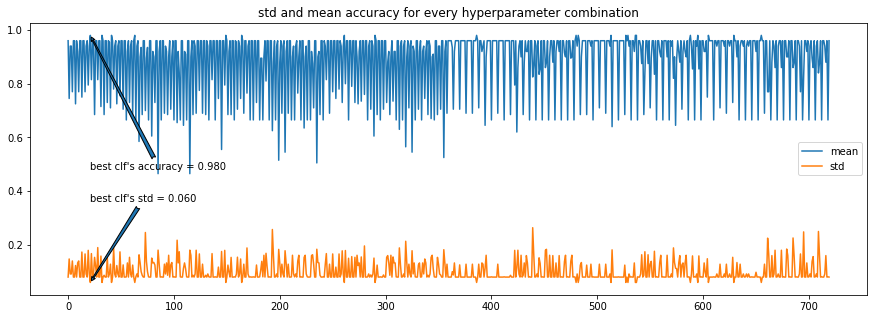

In [43]:
############################## RESULTS

# Best paramete set
print('Best parameters found:\n', clf_golub_sk.best_params_)
print('Best accuracy: ', clf_golub_sk.best_score_)


# All results
means = clf_golub_sk.cv_results_['mean_test_score']
stds = clf_golub_sk.cv_results_['std_test_score']
# show std and mean for every combination
"""for mean, std, params in zip(means, stds, clf_breast_sk.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

# plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(means, label="mean")
plt.plot(stds, label="std")

# localise best param combination
xmax = clf_golub_sk.best_index_
accmax = means[xmax]
stdmax = stds[xmax]

ax.annotate('best clf\'s accuracy = '+"%.3f" % accmax, xy=(xmax, accmax), xytext=(xmax, accmax-0.5),arrowprops=dict(arrowstyle ='fancy'))
ax.annotate('best clf\'s std = '+"%.3f" % stdmax, xy=(xmax, stdmax), xytext=(xmax, stdmax+0.3),arrowprops=dict(arrowstyle ='fancy'))

plt.title("std and mean accuracy for every hyperparameter combination")
plt.legend(loc="best")
plt.show()

> The best model is an MLP with parameters displayed in the previous cell. <br>
> The best model achieves a mean accuracy of $0.98$.

In [71]:
golub_y_test, golub_y_pred = golub_y_test , clf_golub_sk.predict(golub_X_test)
print('We get the following results on the test set :')
print(classification_report(golub_y_test, golub_y_pred))
best_mlp_acc_golub = accuracy_score(golub_y_test, golub_y_pred)

We get the following results on the test set :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



> This model achieves a prefect accuracy on the test set.

## 2 - 2 - Using Keras :
> In this subsection we use sklearn's MLP to perform binary classification on our golub dataset with keras. For hyperparameter tuning we will use grid search with a 10 folds cross validation. We will try to fine tune the same hyperparameters in order to compare the results afterwards (however more parameters are available in keras :  droupout, weight initialisation...).

**1 - Let's create our model :**
> It is in the models.py file to reduce the length of the notebook.

In [45]:
# test shapes
import tensorflow as tf
mlp_toy_keras = MLP(2, 2)
x = tf.ones((3, 2))
y = mlp_toy_keras(x)
print(y)

tf.Tensor(
[[0.47643223 0.5235678 ]
 [0.47643223 0.5235678 ]
 [0.47643223 0.5235678 ]], shape=(3, 2), dtype=float32)


**2 - Get input dim and number of classes :**

In [103]:
input_dim = medical_data["golub"][0].shape[1]
num_classes = np.unique(medical_data["golub"][1]).shape[0]
print("input dim : ", input_dim)
print("num classes : ", num_classes)

input dim :  3562
num classes :  2


**3 - Parameter Space and GridSearch :**
> In order to perform Sklearn's GridSearch we wrap our model with the **KerasClassifier** class.

In [104]:
mlp_golub_keras = KerasClassifier(build_fn=MLP, verbose=0)

In [105]:
# hyperparameters to test

# hidden layers
hidden_layers = []
pow_2 = [ 2**j for j in range(4,10)]
for i in range(len(pow_2)-1):
    hidden_layers.append((pow_2[i], pow_2[i+1]))
# l2 regularization
alpha = [10**-i for i in range(2, 5)]
# learning rate
lr = [10**-i for i in range(2, 5)]
# batch size
batch_size = [ 2**j for j in range(4,8)]


# parameter space
parameter_space = {
    'input_dim' : [input_dim],
    'num_classes' : [num_classes],
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    'learning_rate_init': lr,
    'batch_size' : batch_size,
    'epochs' : [100]
}
print("parameters to test : ", parameter_space)

parameters to test :  {'input_dim': [3562], 'num_classes': [2], 'hidden_layer_sizes': [(16, 32), (32, 64), (64, 128), (128, 256), (256, 512)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.001, 0.0001], 'learning_rate_init': [0.01, 0.001, 0.0001], 'batch_size': [16, 32, 64, 128], 'epochs': [100]}


In [106]:
# We perform our grid search and get the best found accuracy (and other metrics)
clf_golub_keras = GridSearchCV(mlp_golub_keras, parameter_space, n_jobs=-1, cv=10, verbose=1)
t0 = time.time()
clf_golub_keras.fit(golub_X_train, golub_y_train)
t1 = time.time()
print("Grid Search took : ", (t1-t0)/60, " mn")

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 24.4min finished


Grid Search took :  24.400552487373353  mn


In [107]:
joblib.dump(clf_golub_keras.cv_results_, './cv_results/cv_results_golub_keras.pkl')
cv_results_golub_keras = joblib.load("./cv_results/cv_results_golub_keras.pkl")

**4 - Results :**

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 16, 'epochs': 100, 'hidden_layer_sizes': (128, 256), 'input_dim': 3562, 'learning_rate_init': 0.0001, 'num_classes': 2, 'solver': 'adam'}
Best accuracy:  0.9800000011920929


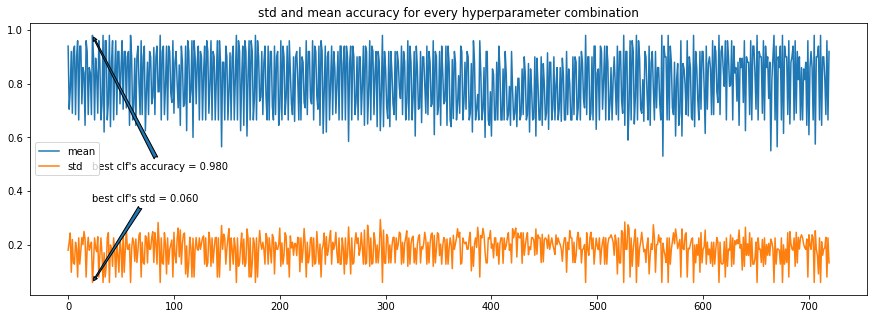

In [108]:
############################## RESULTS

# Best paramete set
print('Best parameters found:\n', clf_golub_keras.best_params_)
print('Best accuracy: ', clf_golub_keras.best_score_)


# All results
means = clf_golub_keras.cv_results_['mean_test_score']
stds = clf_golub_keras.cv_results_['std_test_score']
# show std and mean for every combination
"""for mean, std, params in zip(means, stds, clf_breast_sk.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))"""

# plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
plt.plot(means, label="mean")
plt.plot(stds, label="std")

# localise best param combination
xmax = clf_golub_keras.best_index_
accmax = means[xmax]
stdmax = stds[xmax]

ax.annotate('best clf\'s accuracy = '+"%.3f" % accmax, xy=(xmax, accmax), xytext=(xmax, accmax-0.5),arrowprops=dict(arrowstyle ='fancy'))
ax.annotate('best clf\'s std = '+"%.3f" % stdmax, xy=(xmax, stdmax), xytext=(xmax, stdmax+0.3),arrowprops=dict(arrowstyle ='fancy'))

plt.title("std and mean accuracy for every hyperparameter combination")
plt.legend(loc="best")
plt.show()

> The best model is an MLP with parameters displayed in the previous cell. <br>
> Similarly to using sklearn, the best model achieves a mean accuracy of $0.98$.

In [109]:
golub_y_test, golub_y_pred = golub_y_test , clf_golub_keras.predict(golub_X_test)
print('We get the following results on the test set :')
print(classification_report(golub_y_test, golub_y_pred))

We get the following results on the test set :
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.90      1.00      0.95         9

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



> The best keras MLP achieves a lower accuracy score then sklearn's best MLP (0.96 vs 1.0).

## 2 - 3 - Trends in Parameter Space :
> In this subsection, we will analyse the results obtained across the parameter space. We will see if there are trends (wrt to accuracy and std) in this space. This allows to zoom on parts of the parameter space that seem optimal and design finer grained grids.

**1 - Optimisation : Learning Rate vs Batch Size vs Optimizer :**

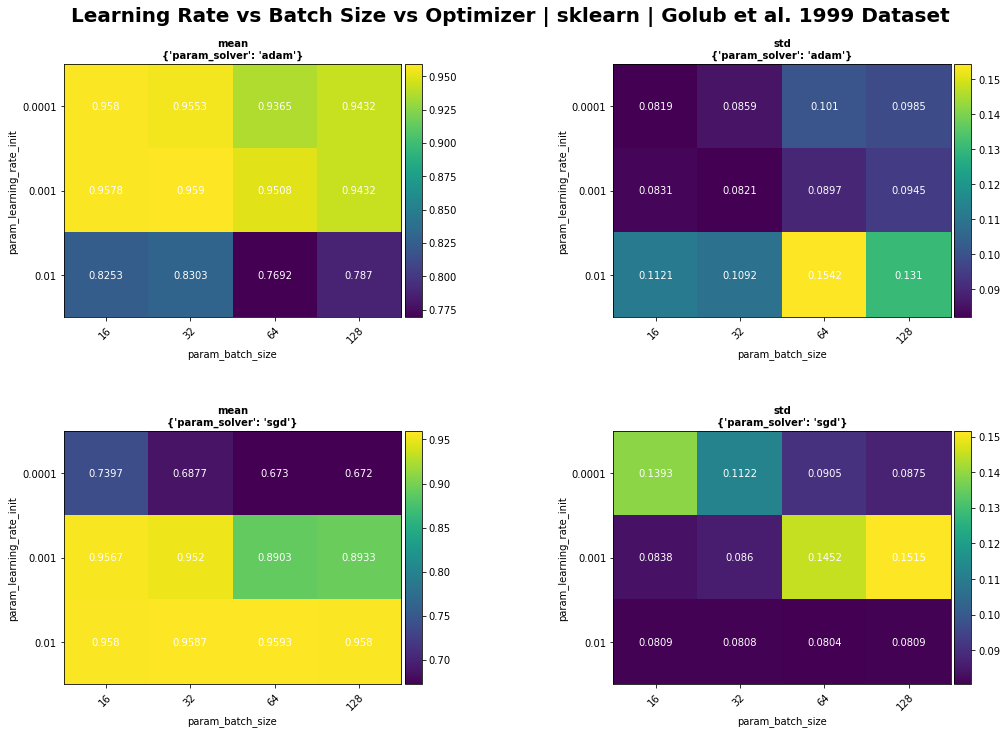

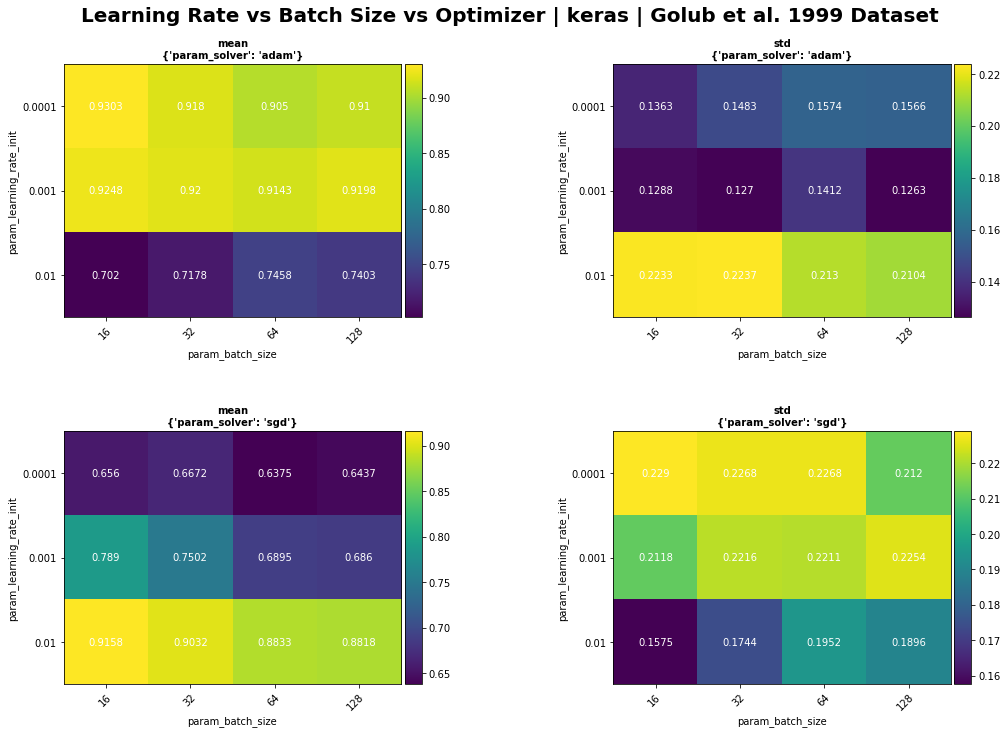

In [53]:
cv_results_golub = {"sklearn":cv_results_golub_sk,"keras":cv_results_golub_keras}
param_names = ["param_learning_rate_init", "param_batch_size"]
with_values = [{"param_solver" : "adam"}, {"param_solver" : "sgd"}]
for i,cv_res in enumerate(cv_results_golub):
    cv_result = cv_results_golub[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle("Learning Rate vs Batch Size vs Optimizer | "+cv_res+" | Golub et al. 1999 Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.15, hspace = 0.45)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

**2 - Network : Hidden Layers vs $\alpha$ the weight of the $l_2$ regularization vs Activation :**

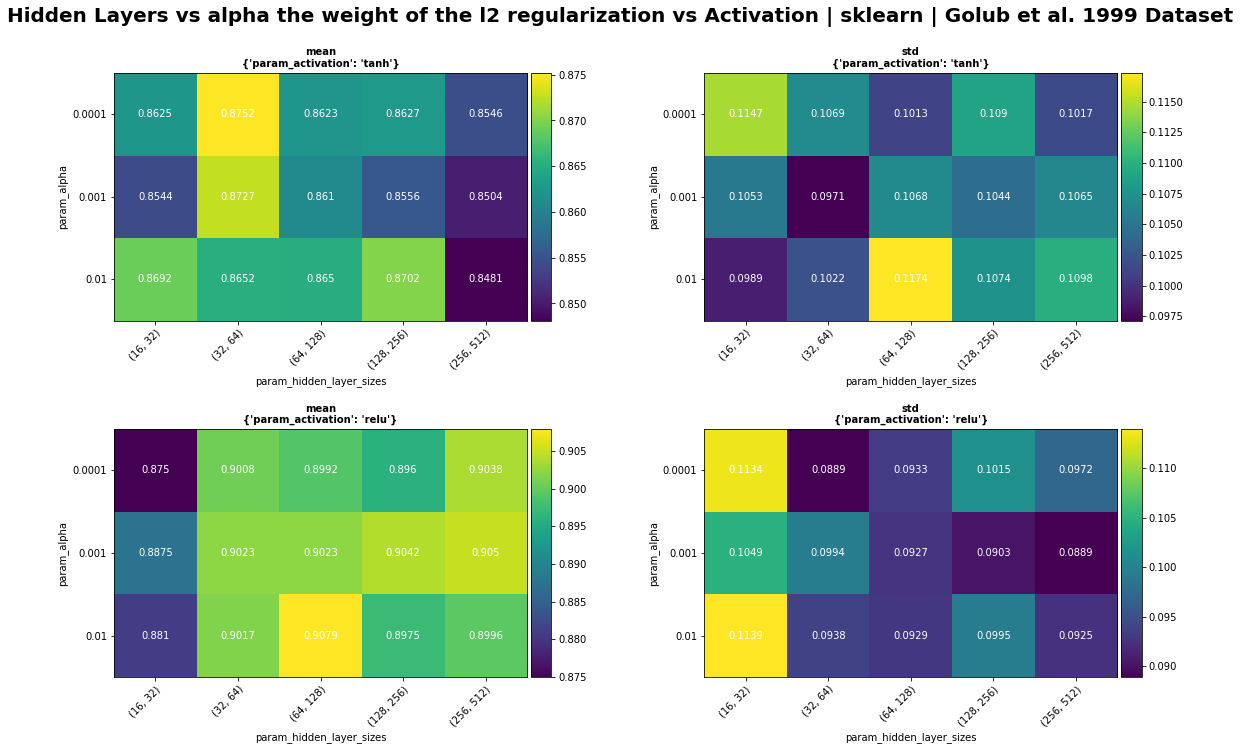

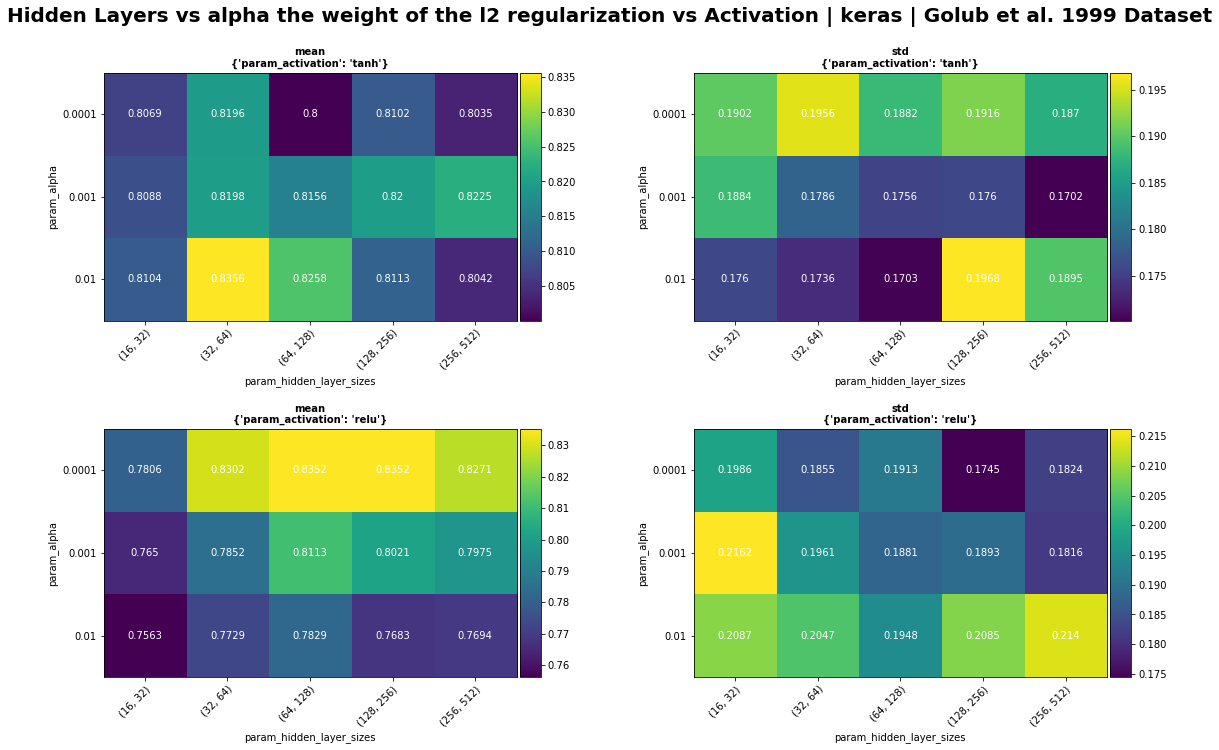

In [83]:
cv_results_golub = {"sklearn":cv_results_golub_sk,"keras":cv_results_golub_keras}
param_names = ["param_alpha", "param_hidden_layer_sizes"]
with_values = [{"param_activation" : "tanh"}, {"param_activation" : "relu"}]
for i,cv_res in enumerate(cv_results_golub):
    cv_result = cv_results_golub[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle("Hidden Layers vs alpha the weight of the l2 regularization vs Activation | "+cv_res+" | Golub et al. 1999 Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.35, wspace= 0.35)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

**3 - The Most Discriminative Network Parameter vs The Most Discriminative Optimisation Parameters : Hidden Layers vs batch_size vs Learning Rate**

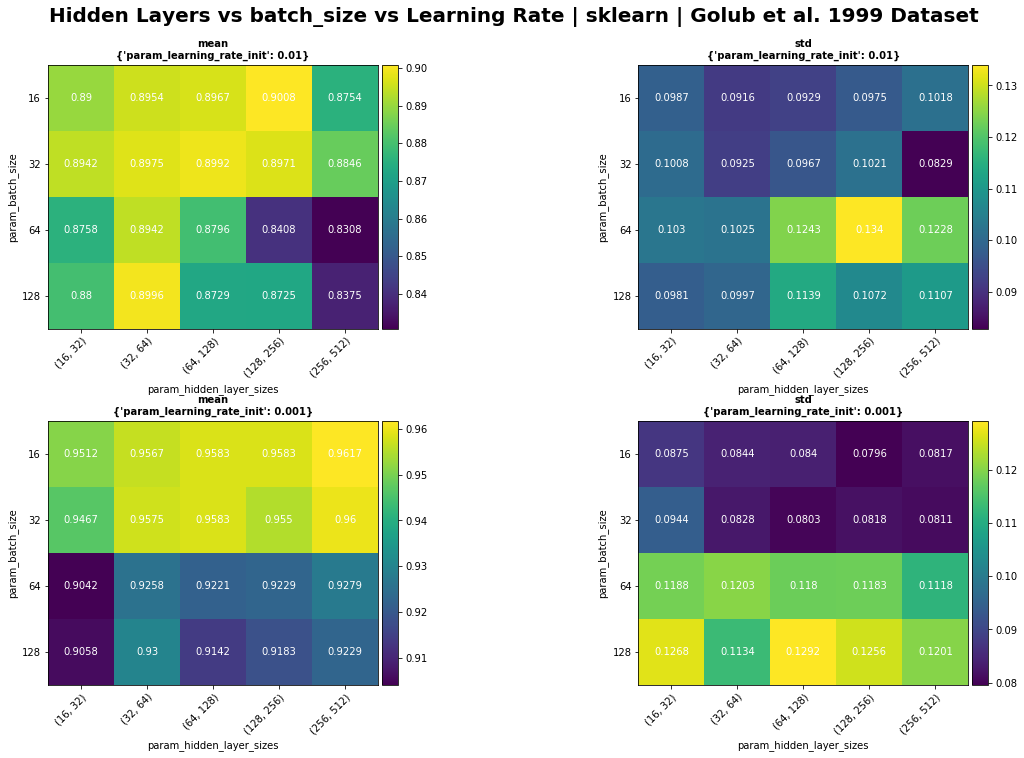

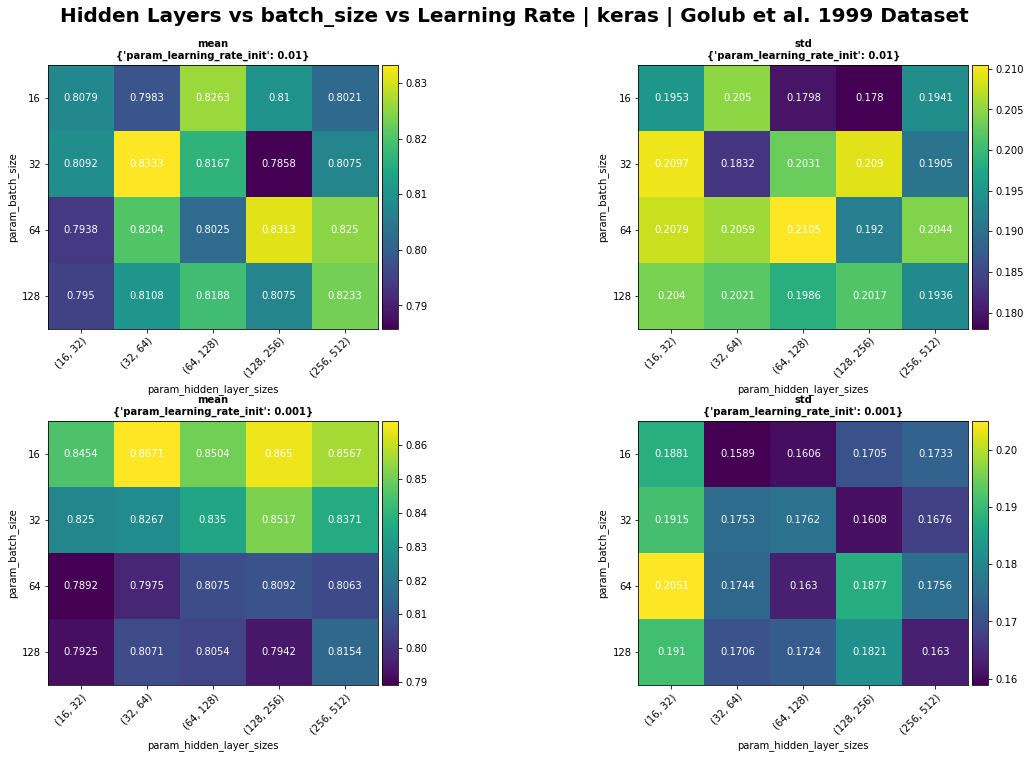

In [55]:
cv_results_golub = {"sklearn":cv_results_golub_sk,"keras":cv_results_golub_keras}
param_names = ["param_batch_size", "param_hidden_layer_sizes"]
with_values = [{"param_learning_rate_init" : 0.01}, {"param_learning_rate_init" : 0.001}]
for i,cv_res in enumerate(cv_results_golub):
    cv_result = cv_results_golub[cv_res]
    
    # plot the true repartition
    
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 10))
    fig.suptitle(" Hidden Layers vs batch_size vs Learning Rate | "+cv_res+" | Golub et al. 1999 Dataset", fontsize=20, fontweight='bold')
    # layout and space between the two heatmaps
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.35, wspace= 0.35)
    fig.subplots_adjust(top=0.9)
    
    axes_1 = (ax1, ax2) 
    axes_2 = (ax3, ax4) 
    
    plot_param_sapace_2D(cv_result, param_names, fig, axes_1, with_values[0])
    plot_param_sapace_2D(cv_result, param_names, fig, axes_2, with_values[1])

## 2 - 4 - Finer Grained Grids :
> Since we already get perfect accuracy on the test set with sklearn's MLP we skip this step for the golub dataset.

# 3 - Comparison with Machine Learnig Algorithms :
> In this subsection, we compare the results obtained with an MLP and the results that we can obtain with traditional Machine Learning Algorithms. We will test three algorithms: SVM, Gradient Boosting and Random Forests. For a fair comparison, we will preform grid search for each algorithm with a 10 folds cross-validation.

In [56]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [88]:
# SVM
svm_clf = SVC()
parameter_space_svm = {
    "C" : [0.1, 0.5, 1],
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    "gamma" : ["scale", "auto"]
}
# Random forests
rf_clf = RandomForestClassifier(random_state=0)
parameter_space_rf = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2, 5, 10, None],
    "max_features" : ["auto", "sqrt", "log2", None],
    "n_estimators" : [50, 100, 200, 300],
    "n_jobs" : [-1]
}
# Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state = 0)
parameter_space_gb = {
    "learning_rate" : [0.1, 0.5, 1],
    "n_estimators" : [50, 100, 200, 300],
    "criterion" : ["friedman_mse", "mse", "mae"],
    "max_depth" : [2, 5, 10, 15]
}
classifiers_ml = {"svm" : svm_clf, "random forests" : rf_clf, "gradient boosting" : gb_clf}
param_grids_ml = {"svm" : parameter_space_svm, "random forests" : parameter_space_rf, "gradient boosting" : parameter_space_gb}
# create keys for results
results = {conf : {clf : {"best cross val acc" :0, "best cross val std":0, "acc on test":0} for clf in classifiers_ml} for conf in medical_data}

In [89]:
%%time
for configuration in medical_data:
    print("Starting Grid Search for the "+configuration+" dataset : ")
    X_train, X_test, y_train, y_test = train_test_split(medical_data[configuration][0], medical_data[configuration][1], test_size=0.33, random_state=42)
    for clf in classifiers_ml:
        print("-"+clf+" : ")
        gs_clf = GridSearchCV(classifiers_ml[clf], param_grids_ml[clf], n_jobs=-1, cv=10, verbose=1)
        gs_clf.fit(X_train, y_train)
        results[configuration][clf]["acc on test"] = gs_clf.best_estimator_.score(X_test, y_test)
        results[configuration][clf]["best cross val acc"] = gs_clf.best_score_
        results[configuration][clf]["best cross val std"] = gs_clf.cv_results_['std_test_score'][gs_clf.best_index_]
        print("\t best params for "+clf+" : "+str(gs_clf.best_params_))
        print("\t Cross Val score of best "+clf+" : "+str(results[configuration][clf]["best cross val acc"]))
        print("\t Acc on test set of best "+clf+" : "+str(results[configuration][clf]["acc on test"]))

Starting Grid Search for the breast dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
	 Cross Val score of best svm : 0.976315789473684
	 Acc on test set of best svm : 0.9840425531914894
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   56.7s finished


	 best params for random forests : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.9631578947368421
	 Acc on test set of best random forests : 0.9521276595744681
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.4min finished


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 2, 'n_estimators': 300}
	 Cross Val score of best gradient boosting : 0.968421052631579
	 Acc on test set of best gradient boosting : 0.9627659574468085
Starting Grid Search for the golub dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
	 Cross Val score of best svm : 0.9800000000000001
	 Acc on test set of best svm : 1.0
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:  1.6min finished


	 best params for random forests : {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.9800000000000001
	 Acc on test set of best random forests : 0.9166666666666666
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 11.3min finished


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 2, 'n_estimators': 50}
	 Cross Val score of best gradient boosting : 0.9550000000000001
	 Acc on test set of best gradient boosting : 0.8333333333333334
CPU times: user 13.9 s, sys: 412 ms, total: 14.3 s
Wall time: 19min 20s


In [90]:
# adding MLP's results (we compare with keras mlp)
# on breast we compare with fine grained keras
best_index = np.argmax(cv_results_breast_keras_finer_grained['mean_test_score'])
best_acc = cv_results_breast_keras_finer_grained['mean_test_score'][best_index]
best_std = cv_results_breast_keras_finer_grained['std_test_score'][best_index]
results["breast"]["MLP"] = {"best cross val acc" :best_acc, "best cross val std":best_std, "acc on test":best_mlp_acc_breast}
# on golub we use plain keras
best_index = np.argmax(cv_results_golub_sk['mean_test_score'])
best_acc = cv_results_golub_sk['mean_test_score'][best_index]
best_std = cv_results_golub_sk['std_test_score'][best_index]
results["golub"]["MLP"] = {"best cross val acc" :best_acc, "best cross val std":best_std, "acc on test":best_mlp_acc_golub}

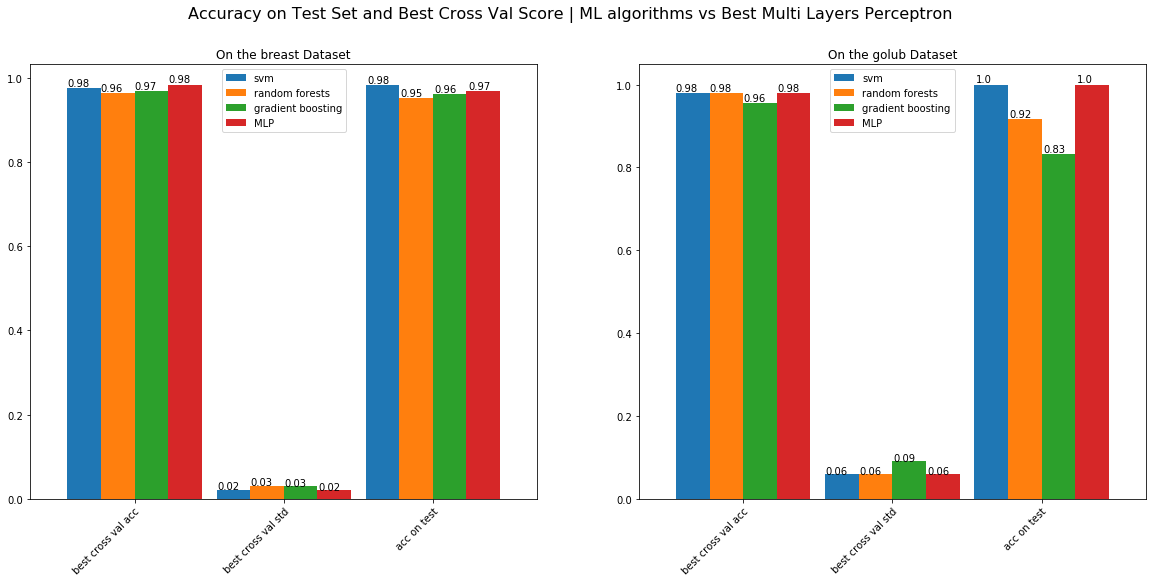

In [92]:
plt.figure(figsize=(20, 8))
plt.suptitle("Accuracy on Test Set and Best Cross Val Score | ML algorithms vs Best Multi Layers Perceptron", fontsize=16)
for i,config in enumerate(results):
    # plot the true repartition
    ax = plt.subplot(1, 2, i+1)
    res_ml_df = pd.DataFrame(results[config])
    res_ml_df.plot(ax=ax, kind="bar", width=0.9)
    ax.set_title("On the "+config+" Dataset")
    # layout for the x labes
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    # also show the value on top of barplots
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig("./figs/comparison_mlp_ml.png")

> On the breast cancer dataset:
> * The four algorithms achieve comparable cross-validation scores (0.98-0.97) and standard deviation across folds (0.02, 0.03) wich suggests that the classification task on this dataset is relatively easy. On the test set, SVM achieves the best accuracy (0.98) followed by the MLP (0.97) then the gradient boosting classifier (0.96) and finally the random forests classifer (0.95).


> On the dataset from Golub et al. 1999:
> * SVM, random forests and the MLP achieve the same cross-validation scores (0.98) and std across folds (0.06), followed by gradient boosting with a cross-validation score of 0.96 and an std across folds of 0.09. However, on the test set, only SVM and the MLP achieve a perfect accuracy of 1. Degraded performances are obtained with random forests (0.92) and gradient boosting (0.83). This dataset is extremely small, it is difficult to draw conclusions on the efficiency of these methods in this context.


> **Overall, we can say that due to the small size of these datasets, and their high dimension, a deep learning approach doesn't allow us to improve the results that can be obtained with traditional machine learning approaches like support vector machines.**